# Simple pendulum

In [6]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import os, sys

# Get the path two folders up
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
# Add the path to the sys.path
sys.path.append(path_to_add)

from matplotlib import pyplot as plt

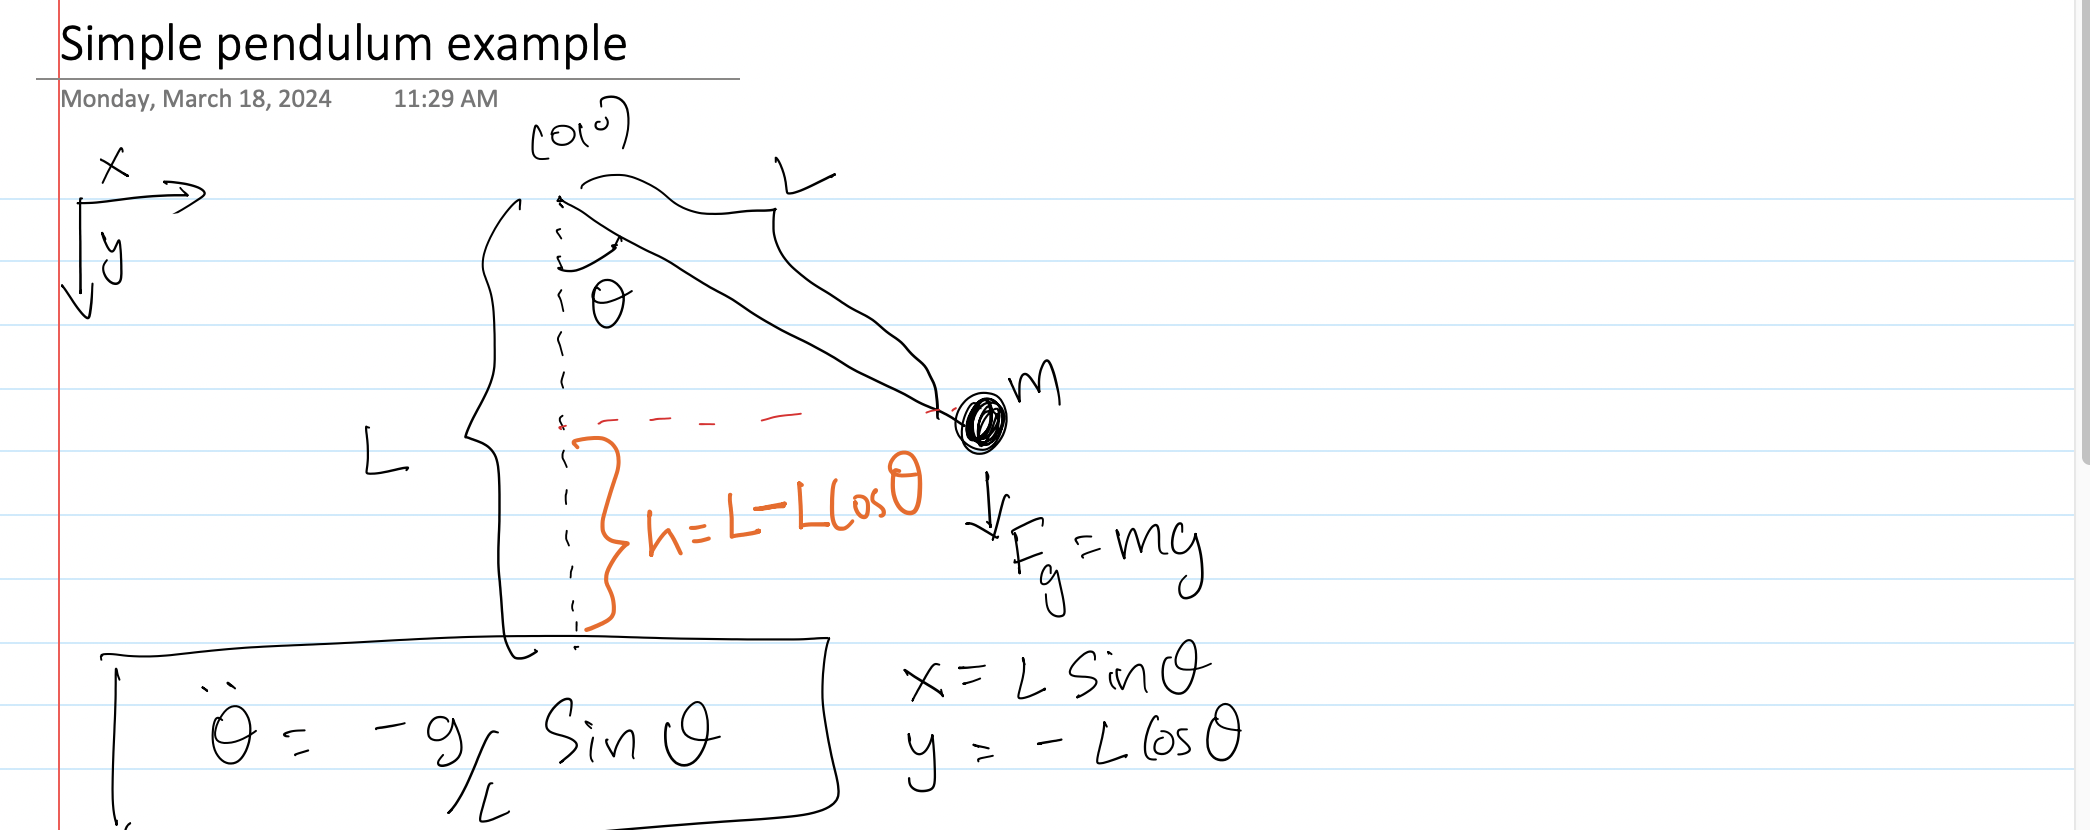

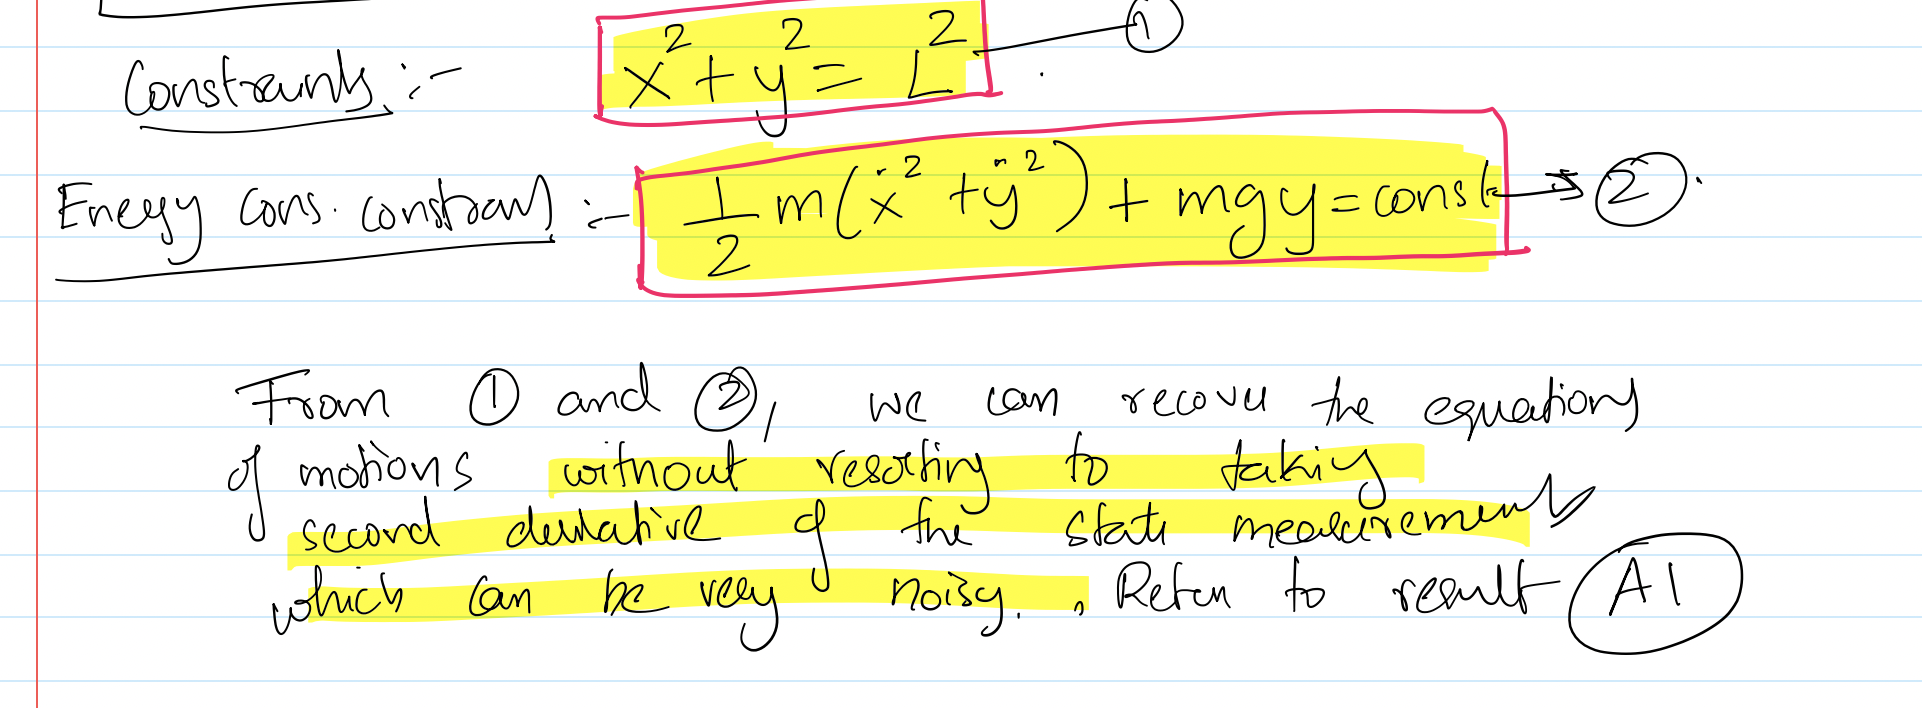

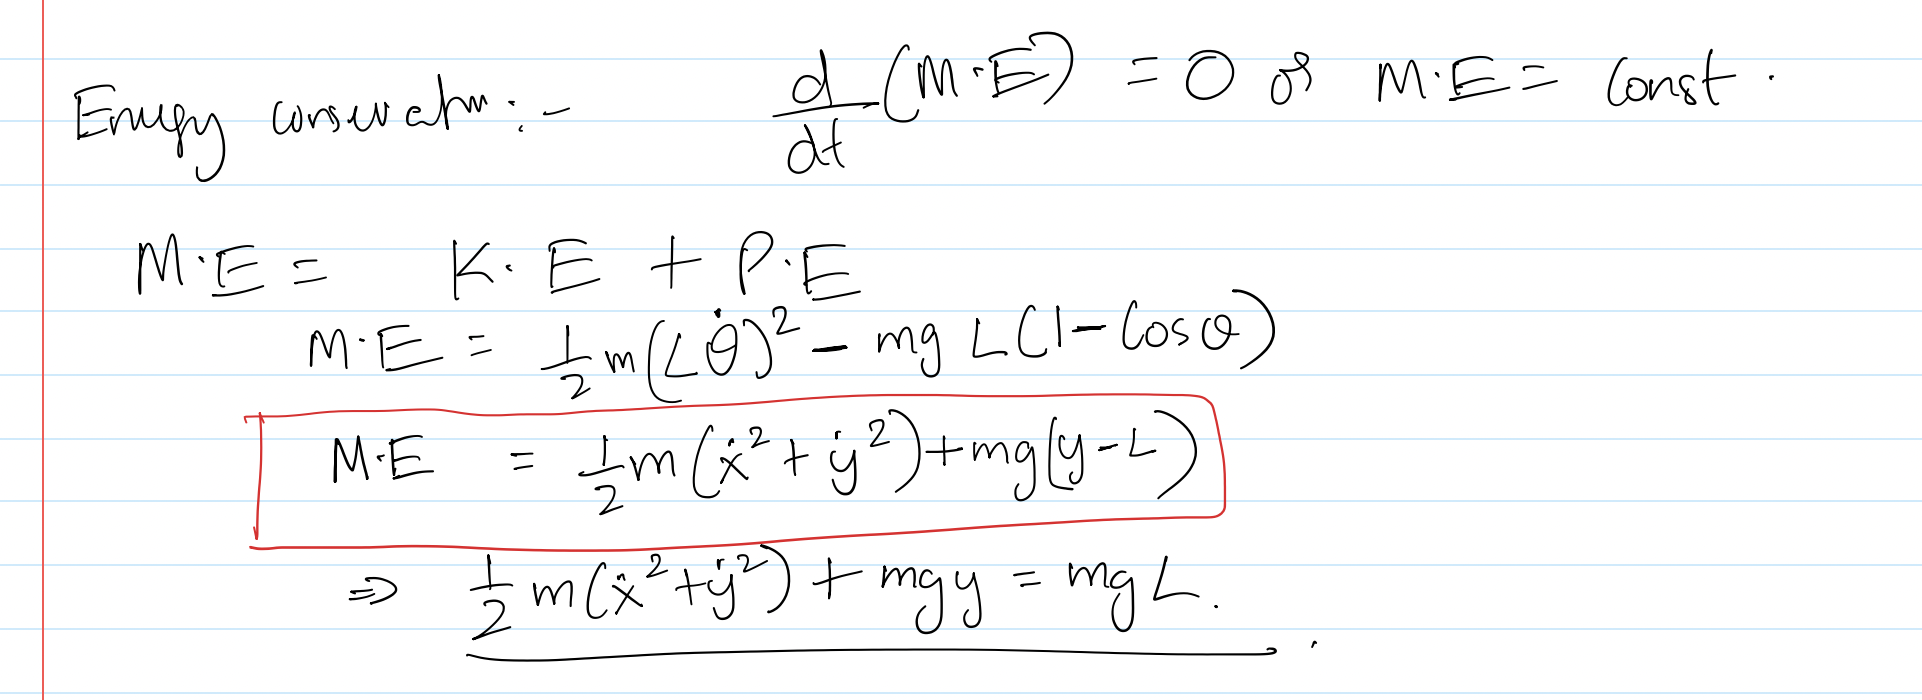

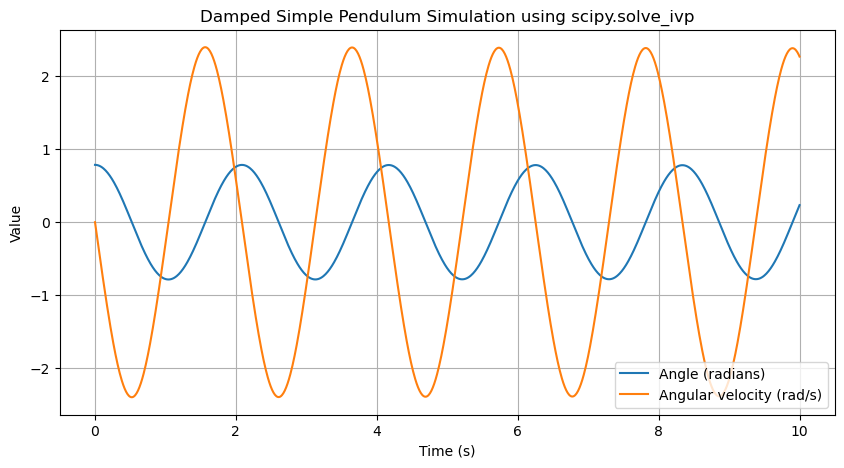

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Function to compute derivatives
def pendulum_rhs(t, y, gamma, L=1):
    """
    Function to compute derivatives for simple pendulum with damping
    
    Parameters:
        t : float
            Time
        y : array_like
            Vector containing [theta, omega], where
            theta is the angle and omega is the angular velocity
        gamma : float
            Damping coefficient
        L : float
            Length of the pendulum
        
    Returns:
        dydt : array_like
            Vector containing [omega, alpha], where
            omega is the angular velocity and alpha is the angular acceleration
    """
    theta, omega = y
    alpha = - (9.81 / L) * np.sin(theta) - gamma * omega
    return [omega, alpha]

# Parameters
theta0 = np.pi / 4  # Initial angle (radians)
omega0 = 0.0        # Initial angular velocity (radians per second)
gamma = 0.0       # Damping coefficient
L = 1.0             # Length of the pendulum (meters)
t_span = (0, 10)    # Time span for the simulation

# Function to integrate the system of ODEs
def integrate_pendulum(t_span, y0, gamma, L):

    sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, y0, method='RK45', t_eval=np.linspace(*t_span, 1000))
    return sol

# Integrate the pendulum system
sol = integrate_pendulum(t_span, [theta0, omega0], gamma, L)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Angle (radians)')
plt.plot(sol.t, sol.y[1], label='Angular velocity (rad/s)')
plt.title('Damped Simple Pendulum Simulation using scipy.solve_ivp')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
IC_df = pd.read_csv(os.path.join(path_to_add, "parameters/init_cond_simp_pend.csv"))

In [10]:
# IC_df = IC_df[0:2]
IC_df

x  u       theta       omega
0   0  0  2.35619449  0.80000000
1  -1  0  2.35619449 -0.80000000
2 -10  1 -2.35619449  0.80000000
3  -9  0 -2.35619449 -0.80000000

In [11]:
# Mechanical eEnergy level
0.5*(IC_df["omega"])**2 + 9.81*(1-np.cos(IC_df["theta"]))

0   17.06671752
1   17.06671752
2   17.06671752
3   17.06671752
dtype: float64

In [14]:
params_df = pd.read_csv(os.path.join(path_to_add, "parameters/pend_param.csv"))
params_df


l  m_c  m_p
0  1    1    1

In [15]:
g = 9.81   # Acceleration due to gravity (m/s^2)


### Synthesizing data from different ICs

### Synthesizing data from different ICs

In [16]:
L = 5.0
# y_shift = 0.9 * L
# y_shift = 0

num_time_points = 195
# Time span
t_span = (0.0, 10)  # from 0 to 10 seconds
#Valuation points
t_eval_ = np.linspace(t_span[0], t_span[1], num_time_points)
data_matrix_df_list = []


for param_index in params_df.index:
    params = params_df.loc[param_index]
    # Define parameters
    m_c = params['m_c']  # Mass of the cart (kg)
    m_p = params['m_p']  # Mass of the pendulum (kg)
    l = params['l']    # Length of the pendulum (m)
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        y0 = IC.values
                # Parameters
        theta0 = IC["theta"]  # Initial angle (radians)
        omega0 = IC["omega"]        # Initial angular velocity (radians per second)
        gamma = 0.0         # Damping coefficient
        # Solve the ODEs
        # sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], method='RK45', t_eval=t_eval_)
        sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], t_eval=t_eval_, rtol=1e-8)
        
        sol_df = pd.DataFrame(sol.y.T, columns=["theta", "omega"])
        sol_df["x"] = L*np.sin(sol_df["theta"])
        sol_df["y"] = -L*np.cos(sol_df["theta"])
        sol_df["t"] = t_eval_
        data_matrix_df_list.append(sol_df[["t", "x", "y"]])
        # if IC_index == 0:
        #     # Plot the results
        #     plt.figure(figsize=(10, 6))
        #     plt.plot(sol.t, sol.y[0], label='Cart Position (x)')
        #     plt.plot(sol.t, sol.y[2], label='Pendulum Angle (theta)')
        #     plt.xlabel('Time (s)')
        #     plt.ylabel('Position (m) / Angle (rad)')
        #     plt.title('Upright Pendulum on Moving Cart')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

t           x           y
0    0.00000000  3.53553391  3.53553391
1    0.05154639  3.39345606  3.67211873
2    0.10309278  3.25954306  3.79148771
3    0.15463918  3.13469420  3.89534238
4    0.20618557  3.01958380  3.98523697
..          ...         ...         ...
775  9.79381443 -4.71717852  1.65777768
776  9.84536082 -4.83126585  1.28797138
777  9.89690722 -4.92093100  0.88568510
778  9.94845361 -4.97954129  0.45185016
779 10.00000000 -4.99998703 -0.01139044

[780 rows x 3 columns]

In [17]:
print("# data points per IC: {}".format(data_matrix_df.shape[0]/len(IC_df)))


# data points per IC: 195.0


In [18]:
from dae_finder import add_noise_to_df
noise_perc = 15

data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["t"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["t"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [19]:
from scipy import interpolate

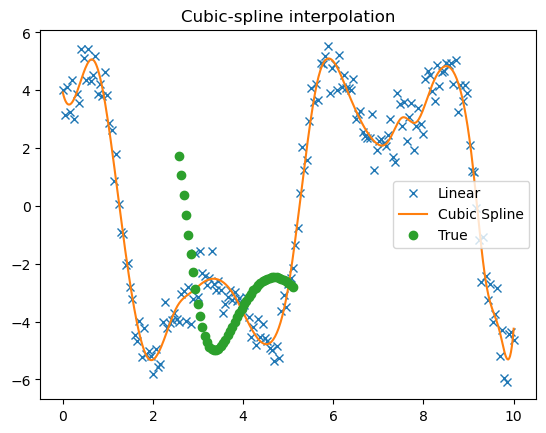

In [20]:
#smoothing parameter: when equal weightage: num_data_points * std of data
s_param = num_time_points * (0.01*noise_perc*data_matrix_df_list[1].std()["x"])**2

tck = interpolate.splrep(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], s=s_param)
t_eval_new = np.linspace(t_span[0], t_span[1], 500)
x_new = interpolate.splev(t_eval_new, tck, der=0)

plt.figure()
plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
        data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")
plt.legend(['Linear', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()

In [21]:
(3/4)*np.pi

2.356194490192345

<Axes: >

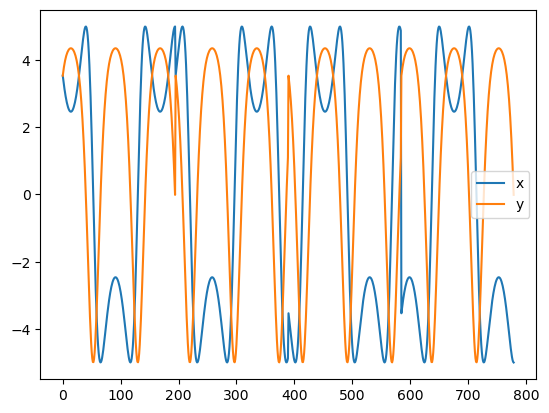

In [22]:
data_matrix_df[["x","y"]].plot()

### Smoothing data and finding derivatives

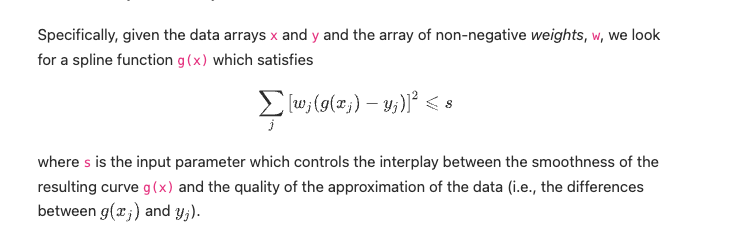

from dae_finder import der_matrix_calculator

from scipy import interpolate

def der_label(feature, der=1):
    if der==0:
        return feature
    elif der==1:
        return "d({}) /dt".format(feature)
    else:
        return "d^{}({}) /dt^{}".format(der, feature, der)

def smooth_data(data_matrix, domain_var = "t", s_param=None, noise_perc=0, derr_order = 1, eval_points = []):
    assert domain_var in data_matrix, "domain variable not found in the data matrix"

    data_t = data_matrix[domain_var]
    num_time_points = len(data_matrix)
    find_s_param = !s_param and s_param !=0

    if len(eval_points)==0:
        eval_points = np.linspace(data_t.iloc[0], data_t.iloc[-1], 10*num_time_points)
    t_eval_new = eval_points
               
    data_matrix_ = data_matrix.drop(domain_var, axis=1)
    data_matrix_std = data_matrix_.std()

    data_matrix_smooth = pd.DataFrame(t_eval_new, columns=[domain_var])
    for feature in data_matrix_:
        if find_s_param:
            #smoothing parameter: when equal weightage: num_data_points * std of data
            s_param = num_time_points * (0.01*noise_perc*data_matrix_std[feature])**2
        tck = interpolate.splrep(data_t, data_matrix_[feature], s=s_param)
        for der_ind in range(derr_order+1):
            smoothed_data = interpolate.splev(t_eval_new, tck, der=der_ind)
            data_matrix_smooth[der_label(feature, der_ind)] = smoothed_data

    return data_matrix_smooth
    



t_eval_new = np.linspace(data_matrix_df_list[1]["t"].iloc[0], data_matrix_df_list[1]["t"].iloc[-1], num_smoothed_points)

smooth_data(data_matrix_df_list[1],derr_order=1, eval_points=t_eval_new, noise_perc=noise_perc) - data_matrix_smooth_df_list[1]

delta_t = t_eval_[1]- t_eval_[0]
data_matrix_features = data_matrix_df_list[0].columns
num_smoothed_points = num_time_points*10
data_matrix_smooth_df_list = []

for ind, data_matrix in enumerate(data_matrix_df_list):
    data_t = data_matrix["t"]
    num_time_points = len(data_matrix)
    data_matrix_ = data_matrix.drop(["t"], axis=1)
    data_matrix_std = data_matrix_.std()
    # print(data_matrix_std)
    t_eval_new = np.linspace(data_t.iloc[0], data_t.iloc[-1], num_smoothed_points)
    data_matrix_smooth = pd.DataFrame(t_eval_new, columns=["t"])
    for feature in data_matrix_:
        #smoothing parameter: when equal weightage: num_data_points * std of data
        s_param = num_time_points * (0.01*noise_perc*data_matrix_std[feature])**2
        # print(s_param)
        # s_param = 0
        
        tck = interpolate.splrep(data_t, data_matrix_[feature], s=s_param)
        smoothed_data = interpolate.splev(t_eval_new, tck, der=0)
        smoothed_derr = interpolate.splev(t_eval_new, tck, der=1)
        data_matrix_smooth[feature] = smoothed_data
        data_matrix_smooth["d({}) /dt".format(feature)] = smoothed_derr

    data_matrix_smooth_df_list.append(data_matrix_smooth)

    
    # derr_matrix = der_matrix_calculator(data_matrix_, delta_t)
    # data_matrix_df_list[ind] = pd.concat([data_matrix_.iloc[:-1], derr_matrix], axis=1)

data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list[:-1], ignore_index=True)

In [23]:
from dae_finder import smooth_data

data_amplify_fact = 1
num_smoothed_points = num_time_points*data_amplify_fact


t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=1, noise_perc=noise_perc, eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list[:-1], ignore_index=True)

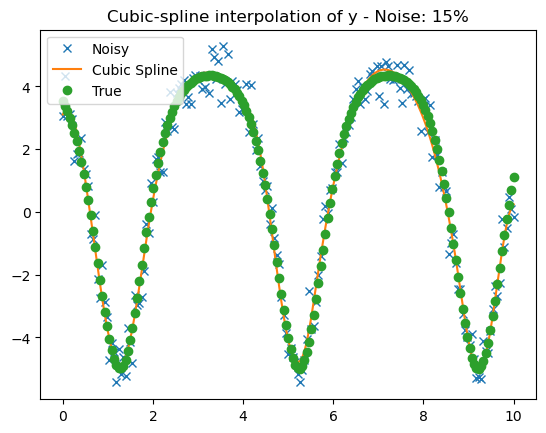

In [24]:
ind = 1
feature_ = "y"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

<Axes: >

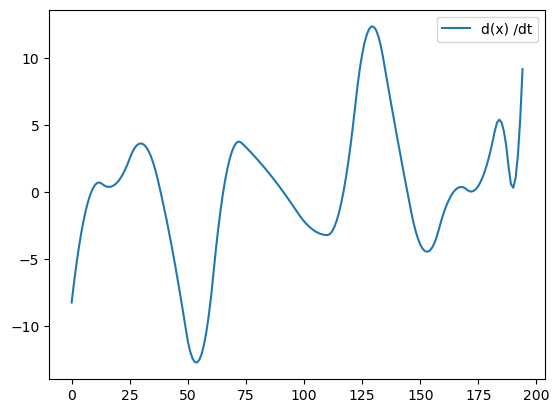

In [25]:
data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

<Axes: >

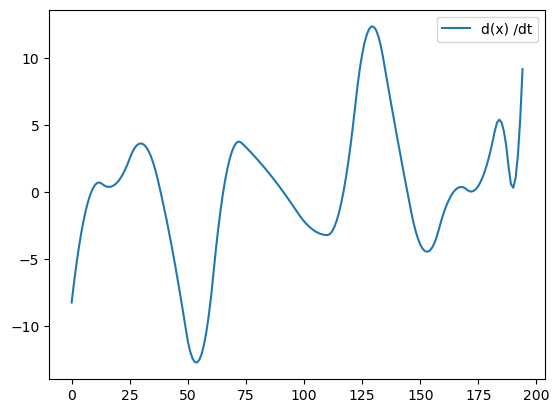

In [26]:
data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

#Taking second derivatives
delta_t = t_eval_[1]- t_eval_[0]
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    derr_matrix = der_matrix_calculator(data_matrix_, delta_t)
    data_matrix_df_list[ind] = pd.concat([data_matrix_.iloc[:-1], derr_matrix], axis=1)

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df_appended

In [27]:
# data_matrix_df = data_matrix_df_appended[["x","y"]]
# data_matrix_df = pd.concat([data_matrix_df, data_matrix_df_appended[["d(u) /dt"]]], axis=1)
data_matrix_df_smooth = data_matrix_df_smooth_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df_smooth = data_matrix_df_smooth.iloc[5:-5]
data_matrix_df_smooth

x           y    d(x) /dt    d(y) /dt
5   2.46051143  4.06679668 -2.25013081  1.49230947
6   2.36601259  4.13984412 -1.43802562  1.34180558
7   2.31003443  4.20511422 -0.75552846  1.19054848
8   2.28589612  4.26256814 -0.20263934  1.03853817
9   2.28691683  4.31216706  0.22064176  0.88577465
..         ...         ...         ...         ...
575 3.47674948 -3.30713302 10.06861815  9.53314768
576 3.96895559 -2.80084911  8.99236279 10.04842186
577 4.40002233 -2.27763037  7.69641087 10.19021897
578 4.75862515 -1.75672820  6.18076237  9.95853902
579 5.03381297 -1.25739400  4.46715477  9.35338199

[575 rows x 4 columns]

## Energy analysis

<Axes: >

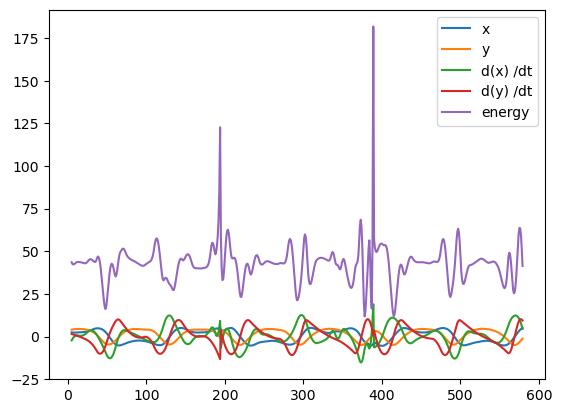

In [28]:
from copy import deepcopy
new_df = deepcopy(data_matrix_df_smooth)

# new_df = new_df.iloc[5:-5]

new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]

new_df.plot()

In [29]:
# data_matrix_df_smooth = new_df[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()].drop("energy", axis=1)
data_matrix_df_smooth = data_matrix_df_smooth[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]

<Axes: >

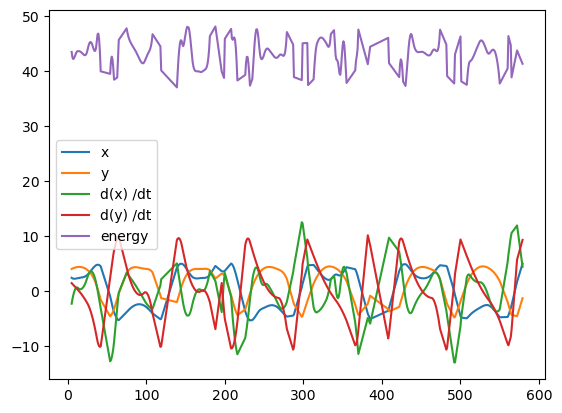

In [30]:
new_df[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()].plot()

## Forming candiate library

from sklearn.preprocessing import FunctionTransformer
from copy import deepcopy

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


data_matrix_df_with_trig = deepcopy(data_matrix_df)
data_matrix_df_with_trig["sin(theta)"] = sin_transformer(1).fit_transform(data_matrix_df_with_trig)["theta"]
data_matrix_df_with_trig["cos(theta)"] = cos_transformer(1).fit_transform(data_matrix_df_with_trig)["theta"]

In [34]:
data_matrix_df_smooth = data_matrix_df_smooth.rename(columns= dict(zip(data_matrix_df_smooth, ['x', 'y', 'x_dot', 'y_dot'])))

In [35]:
from dae_finder import PolyFeatureMatrix
poly_degree = 4
poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)

In [36]:
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

x           y       x_dot       y_dot         x^2         x y  \
0    2.46051143  4.06679668 -2.25013081  1.49230947  6.05411651 10.00639974   
1    2.36601259  4.13984412 -1.43802562  1.34180558  5.59801558  9.79492332   
2    2.31003443  4.20511422 -0.75552846  1.19054848  5.33625906  9.71395861   
3    2.28589612  4.26256814 -0.20263934  1.03853817  5.22532106  9.74378795   
4    2.28691683  4.31216706  0.22064176  0.88577465  5.22998860  9.86156744   
..          ...         ...         ...         ...         ...         ...   
346 -4.35989114 -2.43829367  6.65992034 -9.81400177 19.00865074 10.63069497   
347 -3.06773958 -3.88496890  9.83620955 -8.30817649  9.41102615 11.91807287   
348 -2.54022534 -4.28176157 10.60737674 -7.02202845  6.45274478 10.87663923   
349  1.74654063 -4.53186184 11.97920478  5.74646274  3.05040416 -7.91508081   
350  5.03381297 -1.25739400  4.46715477  9.35338199 25.33927301 -6.32948621   

         x x_dot     x y_dot         y^2      y x_dot  ...   y^2 y_dot^2  \
0    -5.53647258  3.67184452 16.53883528  -9.15082451  ...   36.83178041   
1    -3.40238672  3.17472891 17.13830936  -5.95320191  ...   30.85653583   
2    -1.74529676  2.75020799 17.68298557  -3.17708348  ...   25.06396440   
3    -0.46321247  2.37399038 18.16948713  -0.86376398  ...   19.59690994   
4     0.50458935  2.02569295 18.59478480   0.95144413  ...   14.58940733   
..           ...         ...         ...          ...  ...           ...   
346 -29.03652767 42.78797936  5.94527602 -16.23884160  ...  572.61706491   
347 -30.17492937 25.48732188 15.09298335 -38.21336819  ... 1041.80519867   
348 -26.94512719 17.83753461 18.33348211 -45.41825804  ...  904.00353430   
349  20.92216783 10.03643063 20.53777170 -54.28810098  ...  678.19488725   
350  22.48682162 47.08317556  1.58103966  -5.61697359  ...  138.31844804   

         y x_dot^3  y x_dot^2 y_dot  y x_dot y_dot^2      y y_dot^3  \
0     -46.33143576      30.72747601     -20.37877235    13.51540759   
1     -12.31073149      11.48700554     -10.71839609    10.00121522   
2      -1.81355314       2.85776519      -4.50321620     7.09608902   
3      -0.03546848       0.18177799      -0.93162260     4.77461905   
4       0.04631895       0.18594917       0.74649995     2.99685215   
..             ...              ...              ...            ...   
346  -720.26633163    1061.37831929   -1564.03803315  2304.75309764   
347 -3697.18228326    3122.83332045   -2637.70817887  2227.94613831   
348 -5110.30076446    3382.99263173   -2239.52359633  1482.55301873   
349 -7790.41562858   -3737.08722067   -1792.69265733  -859.96038462   
350  -112.08935778    -234.69403549    -491.40517337 -1028.91001858   

           x_dot^4  x_dot^3 y_dot  x_dot^2 y_dot^2  x_dot y_dot^3  \
0      25.63486672   -17.00130245      11.27543545    -7.47798264   
1       4.27628354    -3.99015223       3.72316631    -3.47404474   
2       0.32583919    -0.51345167       0.80908813    -1.27494687   
3       0.00168615    -0.00864159       0.04428865    -0.22698186   
4       0.00237001     0.00951451       0.03819635     0.15334070   
..             ...            ...              ...            ...   
346  1967.32512125 -2899.03350888    4271.99103737 -6295.16953408   
347  9360.75953524 -7906.58656831    6678.31610531 -5640.85469971   
348 12659.94956008 -8380.82102285    5548.06009958 -3672.78704373   
349 20592.63665570  9878.35347367    4738.67766340  2273.15878678   
350   398.22085250   833.79957507    1745.81950448  3655.41772070   

          y_dot^4  
0      4.95947359  
1      3.24159220  
2      2.00903890  
3      1.16329499  
4      0.61559203  
..            ...  
346 9276.50810035  
347 4764.56059304  
348 2431.36599577  
349 1090.44151912  
350 7653.75726329  

[351 rows x 69 columns]

In [37]:
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))


Degree of library: 4
# terms in the library: 69


In [38]:
corr_matrix = candidate_lib_full.corr()
corr_matrix = pd.DataFrame(np.tril(corr_matrix), columns=candidate_lib_full.columns,
                          index=candidate_lib_full.columns)

correlation_strength = 0.95
terms_to_drop_corr = set()
feature_list = corr_matrix.columns
for feature in corr_matrix:
    set_to_dr = set(corr_matrix[feature] [abs(corr_matrix[feature])>correlation_strength].index)
    set_to_dr.remove(feature)
    terms_to_drop_corr = terms_to_drop_corr.union(set_to_dr)
    print(feature, set_to_dr)
    # terms_to_drop_corr = terms_to_drop_corr.union(set(corr_matrix[feature] [abs(corr_matrix[feature])>correlation_strength].index).remove(feature))
    # print(feature," : ",set(corr_matrix[feature] [abs(corr_matrix[feature])>correlation_strength].index).remove(feature))

x set()
y set()
x_dot set()
y_dot {'x^2 y_dot'}
x^2 {'y^2', 'x^4'}
x y set()
x x_dot set()
x y_dot {'x^3 y_dot'}
y^2 {'y^4'}
y x_dot {'y^3 x_dot'}
y y_dot set()
x_dot^2 {'x_dot^4', 'y x_dot^2', 'y^2 x_dot^2'}
x_dot y_dot set()
y_dot^2 {'x^2 y_dot^2', 'y_dot^4'}
x^3 set()
x^2 y set()
x^2 x_dot {'x y y_dot'}
x^2 y_dot set()
x y^2 set()
x y x_dot set()
x y y_dot set()
x x_dot^2 {'y x_dot y_dot'}
x x_dot y_dot {'y y_dot^2'}
x y_dot^2 set()
y^3 set()
y^2 x_dot set()
y^2 y_dot set()
y x_dot^2 {'y^2 x_dot^2', 'x_dot^4'}
y x_dot y_dot set()
y y_dot^2 set()
x_dot^3 {'y x_dot^3'}
x_dot^2 y_dot set()
x_dot y_dot^2 set()
y_dot^3 set()
x^4 set()
x^3 y set()
x^3 x_dot set()
x^3 y_dot set()
x^2 y^2 set()
x^2 y x_dot {'x y^2 y_dot'}
x^2 y y_dot set()
x^2 x_dot^2 {'x y x_dot y_dot'}
x^2 x_dot y_dot {'x y y_dot^2'}
x^2 y_dot^2 set()
x y^3 set()
x y^2 x_dot set()
x y^2 y_dot set()
x y x_dot^2 {'x_dot^3 y_dot', 'y^2 x_dot y_dot'}
x y x_dot y_dot {'x_dot^2 y_dot^2', 'y^2 y_dot^2'}
x y y_dot^2 set()
x x_dot

In [250]:
terms_to_drop_corr

{'x y x_dot y_dot',
 'x y y_dot',
 'x y y_dot^2',
 'x y^2 y_dot',
 'x^2 y_dot',
 'x^2 y_dot^2',
 'x^3 y_dot',
 'x^4',
 'x_dot^2 y_dot^2',
 'x_dot^3 y_dot',
 'x_dot^4',
 'y x_dot y_dot',
 'y x_dot y_dot^2',
 'y x_dot^2',
 'y x_dot^2 y_dot',
 'y x_dot^3',
 'y y_dot^2',
 'y y_dot^3',
 'y^2',
 'y^2 x_dot y_dot',
 'y^2 x_dot^2',
 'y^2 y_dot^2',
 'y^3 x_dot',
 'y^4',
 'y_dot^4'}

In [251]:
terms_to_drop_corr = terms_to_drop_corr.difference({'y y_dot','y^2'})

In [252]:
terms_to_drop_new = {"x^3", "y^3"}

In [253]:
# candidate_lib_full = candidate_lib_full.drop(terms_to_drop_new, axis=1)
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)


In [254]:
candidate_lib_full.columns

Index(['x', 'y', 'x_dot', 'y_dot', 'x^2', 'x y', 'x x_dot', 'x y_dot', 'y^2',
       'y x_dot', 'y y_dot', 'x_dot^2', 'x_dot y_dot', 'y_dot^2', 'x^3',
       'x^2 y', 'x^2 x_dot', 'x y^2', 'x y x_dot', 'x x_dot^2',
       'x x_dot y_dot', 'x y_dot^2', 'y^3', 'y^2 x_dot', 'y^2 y_dot',
       'x_dot^3', 'x_dot^2 y_dot', 'x_dot y_dot^2', 'y_dot^3', 'x^3 y',
       'x^3 x_dot', 'x^2 y^2', 'x^2 y x_dot', 'x^2 y y_dot', 'x^2 x_dot^2',
       'x^2 x_dot y_dot', 'x y^3', 'x y^2 x_dot', 'x y x_dot^2', 'x x_dot^3',
       'x x_dot^2 y_dot', 'x x_dot y_dot^2', 'x y_dot^3', 'y^3 y_dot',
       'x_dot y_dot^3'],
      dtype='object')

In [255]:
len(candidate_lib_full.columns)

45

candid_lib_comb = pd.concat([candidate_lib_full, data_matrix_df_with_trig[["cos(theta)", "sin(theta)"]]], axis=1)
candid_lib_comb

### SVD analysis

In [256]:
from sklearn import decomposition
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)

# pca_2 = decomposition.PCA()
# pca_2.fit(mean_candidate_lib)

# pca_3 = decomposition.PCA()
# pca_3.fit(selected_data_matrix_df)

pca_2 = decomposition.PCA()
pca_2.fit(candidate_lib_full.drop(["x^2", "x x_dot"],axis=1))

pca_3 = decomposition.PCA()
pca_3.fit(candidate_lib_full.drop(["x^2", "x x_dot", "y"],axis=1))


# singular_values = pca_1.singular_values_
# mean_singular_values = pca_2.singular_values_

var_expl_ratio = pca_1.explained_variance_ratio_
theta_dot_sq_rem_expl_ratio = pca_2.explained_variance_ratio_
theta_dot_rem_expl_ratio = pca_3.explained_variance_ratio_
# data_var_expl_ratio_E = pca_4.explained_variance_

# var_expl_ratio_E_rem = pca_5.explained_variance_


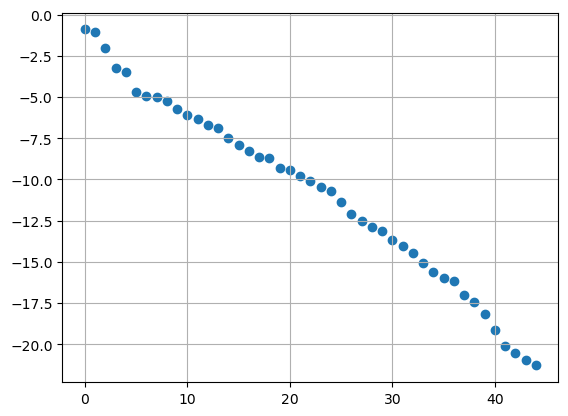

In [257]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(var_expl_ratio)),np.log(var_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

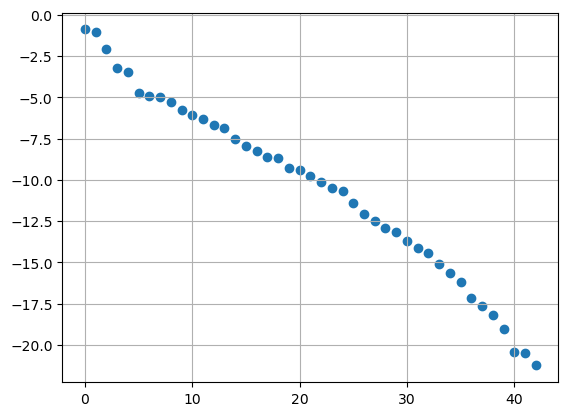

In [258]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(theta_dot_sq_rem_expl_ratio)),np.log(theta_dot_sq_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

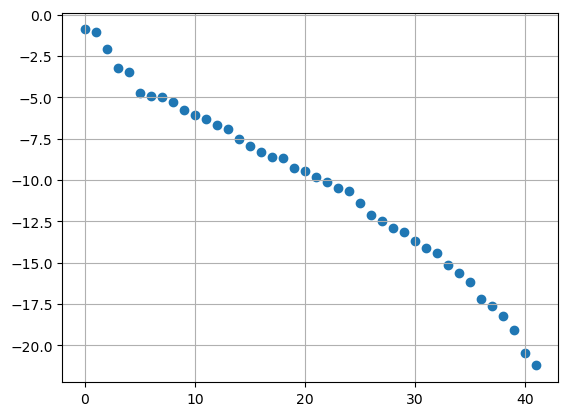

In [259]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(theta_dot_rem_expl_ratio)),np.log(theta_dot_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

### Finding the remaining algebraic relationships

In [260]:
data_matrix_df_smooth

x           y       x_dot       y_dot
5    2.46051143  4.06679668 -2.25013081  1.49230947
6    2.36601259  4.13984412 -1.43802562  1.34180558
7    2.31003443  4.20511422 -0.75552846  1.19054848
8    2.28589612  4.26256814 -0.20263934  1.03853817
9    2.28691683  4.31216706  0.22064176  0.88577465
..          ...         ...         ...         ...
561 -4.35989114 -2.43829367  6.65992034 -9.81400177
564 -3.06773958 -3.88496890  9.83620955 -8.30817649
565 -2.54022534 -4.28176157 10.60737674 -7.02202845
572  1.74654063 -4.53186184 11.97920478  5.74646274
579  5.03381297 -1.25739400  4.46715477  9.35338199

[351 rows x 4 columns]

In [261]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df_smooth.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df_smooth.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")



In [262]:
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder


seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold= 0.1)


algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

In [263]:
features_to_remove = {x**2, x*x_dot}
# features_to_remove = {y**2, y*y_dot}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_smooth,
                                                  candidate_lib_full, get_dropped_feat=True)

In [264]:
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.3, coef_threshold= 0.05)
# seq_th_model = sequentialThLin(model_id="LR", alhp coef_threshold= 0.1)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 7 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential th

AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x140f33650>)

In [265]:
algebraic_model_th.best_models(5)

x_dot^3       x_dot      y_dot         x y      y_dot^3
x               0.00000000  0.00000000 0.00000000  1.79090957   0.00000000
y               0.00000000  0.00000000 0.00000000  0.00000000   0.00000000
x_dot          72.84468166         NaN 0.00000000  0.00000000   0.00000000
y_dot           0.00000000  0.00000000        NaN  0.00000000  85.19284174
x y             0.00000000  0.00000000 0.00000000         NaN   0.00000000
x y_dot         0.00000000 -0.01663321 0.00000000  0.00000000   0.00000000
y^2             0.00000000  0.00000000 0.00000000  0.00000000   0.00000000
y x_dot       -17.93791223  0.18276146 0.00000000  0.00000000   0.00000000
y y_dot         0.00000000  0.00000000 0.21768068  0.00000000 -18.60608993
x_dot^2         0.00000000  0.00000000 0.00000000  0.00000000   0.00000000
x_dot y_dot     0.00000000  0.00000000 0.00000000 -0.12930085   0.00000000
y_dot^2         0.00000000  0.00000000 0.00000000  0.00000000   0.00000000
x y^2           0.00000000  0.00000000 0.00000000  0.04270549   0.00000000
x y_dot^2       0.00000000  0.00000000 0.00000000 -0.01956696   0.00000000
y^3             0.00000000  0.00000000 0.00000000  0.00000000   0.00000000
y^2 x_dot       0.70588142  0.00870252 0.00000000  0.00000000   0.00000000
y^2 y_dot       0.00000000  0.00000000 0.00000000  0.00000000   0.00000000
x_dot^2 y_dot   0.00000000  0.00000000 0.01134788  0.00000000  -0.95781016
x_dot y_dot^2  -0.85086405  0.01067777 0.00000000  0.00000000   0.00000000
y_dot^3         0.00000000  0.00000000 0.01160450  0.00000000          NaN
x y^3           0.00000000  0.00000000 0.00000000  0.02198290   0.00000000
x y_dot^3       0.00000000  0.00020871 0.00000000  0.00000000   0.00000000
y^3 y_dot       0.00000000  0.00000000 0.00000000  0.00000000   0.00000000
x_dot y_dot^3   0.00000000  0.00000000 0.00000000 -0.00037027   0.00000000
x_dot^3                NaN  0.00952046 0.00000000  0.00000000   0.00000000
r2- metric      0.99731335  0.99656858 0.99581393  0.99510864   0.99456056

In [266]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full, scale_columns= True)


algebraic_model_1.best_models(5)

x y     y y_dot     x x_dot           x       x_dot
x                0.00000000  0.00000000 -0.00000000         NaN  0.00000000
y                0.00000000 -0.00000000 -0.00000000 -0.00000000  0.00000000
x_dot            0.00000000 -0.00000000  0.00000000  0.00000000         NaN
y_dot            0.00000000 -0.00000000  0.00000000 -0.00000000 -0.00000000
x^2             -0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
x x_dot          0.00000000 -0.16819653         NaN -0.00000000  0.00000000
x y_dot          0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
y^2             -0.00000000 -0.00000000 -0.00000000 -0.00000000 -0.00000000
y x_dot         -0.00000000 -0.00000000  0.00000000 -0.00000000 -0.00000000
y y_dot         -0.00000000         NaN -0.25102333  0.00000000 -0.00000000
x_dot^2         -0.00000000  0.00000000  0.00000000 -0.00000000 -0.00000000
x_dot y_dot     -0.00000000  0.00000000 -0.00000000  0.00000000  0.00000000
y_dot^2         -0.00000000  0.00000000 -0.00000000  0.00000000 -0.00000000
x^3              0.00000000  0.00000000 -0.00000000  0.02790087  0.00000000
x^2 y            0.00000000 -0.00000000 -0.00000000 -0.00000000  0.00000000
x^2 x_dot       -0.00000000 -0.00000000  0.00000000  0.00000000  0.02381254
x y^2            0.00000000  0.00000000 -0.00000000  0.02323242  0.00000000
x y x_dot       -0.00000000  0.00000000 -0.00000000  0.00000000  0.00000000
x x_dot^2       -0.00000000  0.00000000 -0.00000000  0.00000000  0.00000000
x x_dot y_dot   -0.00000000  0.00000000  0.00000000 -0.00000000 -0.00000000
x y_dot^2       -0.00000000  0.00000000 -0.00000000  0.00000000  0.00000000
y^3              0.00000000 -0.00000000 -0.00000000 -0.00000000  0.00000000
y^2 x_dot        0.00000000 -0.00000000  0.00000000  0.00000000  0.03073939
y^2 y_dot        0.00000000 -0.00000000  0.00000000 -0.00000000 -0.00000000
x_dot^3          0.00000000 -0.00000000 -0.00000000  0.00000000  0.00000000
x_dot^2 y_dot    0.00000000 -0.00000000  0.00000000 -0.00000000 -0.00000000
x_dot y_dot^2    0.00000000 -0.00000000  0.00000000 -0.00000000  0.00000000
y_dot^3          0.00000000 -0.00000000  0.00000000 -0.00000000  0.00000000
x^3 y            0.02529189 -0.00000000  0.00000000  0.00000000 -0.00000000
x^3 x_dot        0.00000000 -0.00000000  0.02139113 -0.00000000  0.00000000
x^2 y^2         -0.00000000  0.00000000 -0.00000000 -0.00000000  0.00000000
x^2 y x_dot     -0.00000000 -0.00000000  0.00000000 -0.00000000 -0.00000000
x^2 y y_dot     -0.00000000  0.01902293 -0.00000000  0.00000000 -0.00000000
x^2 x_dot^2     -0.00000000  0.00000000  0.00000000 -0.00000000 -0.00000000
x^2 x_dot y_dot -0.00000000  0.00000000 -0.00000000  0.00000000  0.00000000
x y^3            0.02819909 -0.00000000  0.00000000  0.00000000  0.00000000
x y^2 x_dot      0.00000000 -0.00000000  0.01380436 -0.00000000  0.00000000
x y x_dot^2      0.00000000 -0.00000000  0.00000000 -0.00000000 -0.00000000
x x_dot^3        0.00000000 -0.00000000  0.00000000 -0.00000000 -0.00000000
x x_dot^2 y_dot  0.00000000 -0.00000000 -0.00000000  0.00000000  0.00000000
x x_dot y_dot^2  0.00000000 -0.00000000  0.00000000 -0.00000000  0.00000000
x y_dot^3        0.00000000 -0.00000000  0.00000000  0.00000000  0.00000000
y^3 y_dot       -0.00000000  0.02186419 -0.00000000  0.00000000 -0.00000000
x_dot y_dot^3   -0.00000000  0.00000000 -0.00000000  0.00000000 -0.00000000
x y                     NaN -0.00000000  0.00000000  0.00000000  0.00000000
r2- metric       0.89012579  0.88410755  0.88254107  0.87825485  0.87782802

In [157]:
features_to_remove = {x**2, x*x_dot}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_smooth,
                                                  candidate_lib_full, get_dropped_feat=True)

In [874]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.2, fit_intercept=True)

# algebraic_model_1.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"], axis=1), scale_columns= True)
algebraic_model_1.fit(refined_candid_lib, scale_columns= True)


algebraic_model_1.best_models(5)

x_dot y_dot^2     y_dot^3         y^3           x       x_dot
x                -0.00000000  0.00000000  0.00000000         NaN  0.00000000
y                -0.00000000  0.00000000  6.37522289  0.00000000  0.00000000
x_dot            44.83351137  0.00000000 -0.00000000  0.00000000         NaN
y_dot             0.00000000 58.98632538  0.00000000 -0.00000000 -0.00000000
x y               0.00000000  0.00000000 -0.00000000  0.04211228  0.00000000
x y_dot           0.00000000 -0.00000000 -0.00000000 -0.00000000 -0.00000000
y^2               0.00000000  0.00000000  1.87045213  0.00000000  0.00000000
y x_dot          -7.95290645 -0.00000000  0.00000000  0.00000000  0.00000000
y y_dot          -0.00000000 -5.37775586 -0.00000000 -0.00000000 -0.00000000
x_dot^2           0.00000000 -0.00000000 -0.17574538 -0.00000000  0.00000000
x_dot y_dot      -0.00000000 -0.00000000  0.00000000 -0.00000000 -0.00000000
x y^2            -0.00000000  0.00000000  0.00000000  0.03439276  0.00000000
x y_dot^2        -0.00000000 -0.00000000  0.00000000  0.00815523 -0.00000000
y^3              -0.00000000  0.00000000         NaN  0.00000000 -0.00000000
y^2 x_dot         0.00000000  0.00000000 -0.00000000  0.00000000  0.05071163
y x_dot^2        -0.00000000  0.00000000  0.00000000  0.00000000 -0.00000000
x_dot^3           0.00000000  0.00000000 -0.00000000 -0.00000000  0.00000000
x_dot^2 y_dot     0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
y_dot^3           0.00000000         NaN  0.00000000  0.00000000  0.00000000
x y^3             0.00000000  0.00000000 -0.00000000  0.00000000  0.00000000
x_dot y_dot^2            NaN  0.00000000 -0.00000000 -0.00000000  0.00428661
r2- metric        0.90917801  0.90365550  0.90276782  0.89643473  0.89568124

In [875]:
from sklearn.linear_model import LinearRegression

In [797]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y x_dot", "y^2 x_dot"]], y=candidate_lib_full["x_dot^3"])
model_lin.score(X=candidate_lib_full[["y x_dot", "y^2 x_dot"]], y=candidate_lib_full["x_dot^3"])

KeyError: 'x_dot^3'

In [798]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y", "x_dot^2"]], y=candidate_lib_full["x_dot^2"])
model_lin.score(X=candidate_lib_full[["y", "x_dot^2"]], y=candidate_lib_full["x_dot^2"])

1.0

In [718]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'y': -1.3657439784125636e-15, 'x_dot^2': 1.0000000000000002}

In [719]:
model_lin.intercept_

3.552713678800501e-15

# FInal param est

In [267]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2"]], y=candidate_lib_full["y"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2"]], y=candidate_lib_full["y"])

0.9918091633484667

In [268]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.051864451499145,
 'y_dot^2': -0.05106337810338052,
 'y^2': 0.002454517776341498}

In [912]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "y^3"]], y=candidate_lib_full["y"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "y^3"]], y=candidate_lib_full["y"])

0.9938652824568117

In [913]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.026412190860826464,
 'y_dot^2': -0.049406277943368125,
 'y^2': -0.09031253560445782,
 'y^3': 0.024188940537223962}

In [247]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "x_dot y_dot"]], y=candidate_lib_full["y"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "x_dot y_dot"]], y=candidate_lib_full["y"])

0.9999068525947747

In [248]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.05104276845691093,
 'y_dot^2': -0.0510480714267504,
 'y^2': -6.73522336734388e-05,
 'x_dot y_dot': -2.1570969168485095e-05}

In [631]:
model_lin.intercept_

AttributeError: 'LinearRegression' object has no attribute 'intercept_'

In [632]:
# Expected coefficient of x_dot^2 and y_dot^2 
1/(9.8*2) #1/2 * 1/g

0.0510204081632653

In [633]:
# Expected intercept (coming from energy)
L #L

5.0

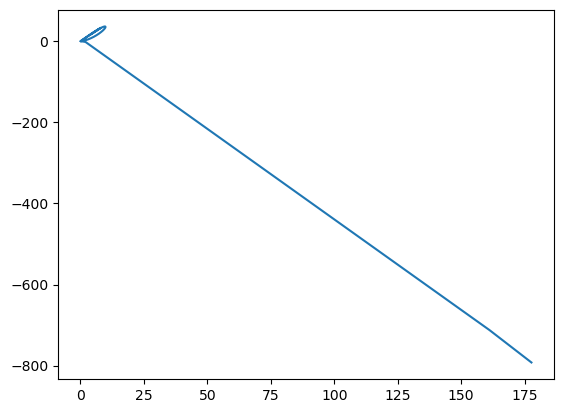

In [634]:
plt.plot(candidate_lib_full["x_dot^2"][:50], candidate_lib_full["y x_dot^2"][:50])

In [540]:
plt.plot(candidate_lib_full["y^3"][:100000], candidate_lib_full["x_dot^2"][:100000])

KeyError: 'y^3'

In [1558]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y^2", "d(y) /dt^2"]], y=candidate_lib_full["x^2"])

In [1559]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

In [1446]:
model_lin.intercept_

<Axes: >

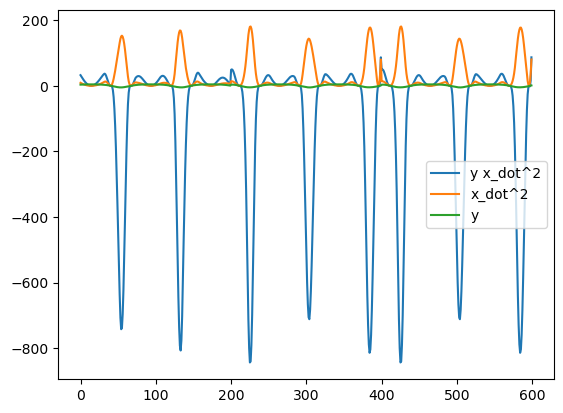

In [69]:
candidate_lib_full[["y x_dot^2", "x_dot^2", "y"]].plot()

# Correlation Heat map

In [42]:
correlation_matrix = corr_matrix
high_correlation_mask = correlation_matrix.abs() >= 0.95

# Step 3: Extract the pairs of features with high correlation
high_correlation_pairs = []

for i in range(len(high_correlation_mask.columns)):
    for j in range(i):
        if high_correlation_mask.iloc[i, j]:
            high_correlation_pairs.append((high_correlation_mask.columns[i], high_correlation_mask.columns[j]))

In [45]:
high_correlation_pairs

[('y^2', 'x^2'),
 ('x^2 y_dot', 'y_dot'),
 ('x y y_dot', 'x^2 x_dot'),
 ('y x_dot^2', 'x_dot^2'),
 ('y x_dot y_dot', 'x x_dot^2'),
 ('y y_dot^2', 'x x_dot y_dot'),
 ('x^4', 'x^2'),
 ('x^3 y_dot', 'x y_dot'),
 ('x^2 y_dot^2', 'y_dot^2'),
 ('x y^2 y_dot', 'x^2 y x_dot'),
 ('x y x_dot y_dot', 'x^2 x_dot^2'),
 ('x y y_dot^2', 'x^2 x_dot y_dot'),
 ('y^4', 'y^2'),
 ('y^3 x_dot', 'y x_dot'),
 ('y^2 x_dot^2', 'x_dot^2'),
 ('y^2 x_dot^2', 'y x_dot^2'),
 ('y^2 x_dot y_dot', 'x y x_dot^2'),
 ('y^2 y_dot^2', 'x y x_dot y_dot'),
 ('y x_dot^3', 'x_dot^3'),
 ('y x_dot^2 y_dot', 'x x_dot^3'),
 ('y x_dot y_dot^2', 'x x_dot^2 y_dot'),
 ('y y_dot^3', 'x x_dot y_dot^2'),
 ('x_dot^4', 'x_dot^2'),
 ('x_dot^4', 'y x_dot^2'),
 ('x_dot^4', 'y^2 x_dot^2'),
 ('x_dot^3 y_dot', 'x y x_dot^2'),
 ('x_dot^3 y_dot', 'y^2 x_dot y_dot'),
 ('x_dot^2 y_dot^2', 'x y x_dot y_dot'),
 ('y_dot^4', 'y_dot^2')]

In [46]:
correlated_terms = ['x^4', 'x^2', 'x^3 y_dot', 'x y_dot','y^4', 'y^2', 'x_dot^4', 'x_dot^2', 'y^3 x_dot', 'y x_dot' ]

In [47]:
candidate_lib_full[correlated_terms]

x^4         x^2     x^3 y_dot     x y_dot          y^4  \
0    36.65232677  6.05411651   22.22977454  3.67184452 273.53307230   
1    31.33777845  5.59801558   17.77218188  3.17472891 293.72164776   
2    28.47566072  5.33625906   14.67582227  2.75020799 312.68797855   
3    27.30398015  5.22532106   12.40486190  2.37399038 330.13026264   
4    27.35278073  5.22998860   10.59435106  2.02569295 345.76602158   
..           ...         ...           ...         ...          ...   
346 361.32880306 19.00865074  813.34175565 42.78797936  35.34630698   
347  88.56741314  9.41102615  239.86185259 25.48732188 227.79814650   
348  41.63791518  6.45274478  115.10105828 17.83753461 336.11656634   
349   9.30496554  3.05040416   30.61516975 10.03643063 421.80006633   
350 642.07875673 25.33927301 1193.05343984 47.08317556   2.49968642   

            y^2        x_dot^4      x_dot^2      y^3 x_dot      y x_dot  
0   16.53883528    25.63486672   5.06308865  -151.34397924  -9.15082451  
1   17.13830936     4.27628354   2.06791768  -102.02781601  -5.95320191  
2   17.68298557     0.32583919   0.57082326   -56.18032124  -3.17708348  
3   18.16948713     0.00168615   0.04106270   -15.69414844  -0.86376398  
4   18.59478480     0.00237001   0.04868279    17.69189881   0.95144413  
..          ...            ...          ...            ...          ...  
346  5.94527602  1967.32512125  44.35453890   -96.54439561 -16.23884160  
347 15.09298335  9360.75953524  96.75101826  -576.75372989 -38.21336819  
348 18.33348211 12659.94956008 112.51644129  -832.67482138 -45.41825804  
349 20.53777170 20592.63665570 143.50134723 -1114.95662380 -54.28810098  
350  1.58103966   398.22085250  19.95547174    -8.88065804  -5.61697359  

[351 rows x 10 columns]

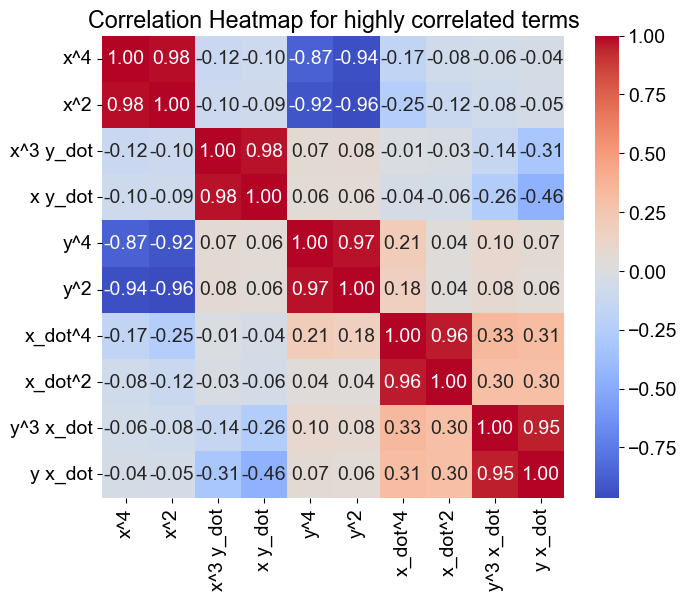

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create a heatmap
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(candidate_lib_full[correlated_terms].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap for highly correlated terms')


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
# plt.xlabel('Noise %')
# plt.ylabel('# Data points/ IC')
# plt.xticks([1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# plt.legend(
#     # loc='lower right',
#     prop={'size': 8},
#     frameon=True,  # Ensure the legend box is visible
#     borderpad=1,  # Padding between the border and the legend content
#     borderaxespad=1,  # Padding between the legend and the axes
#     fancybox=True,  # Rounded border corners (set to False for square corners)
#     edgecolor='black'
# )
# plt.title("Pendulum example: data requirement")

plt.savefig('Example_3_degree_4_heatmap.svg',
            format='svg', bbox_inches='tight')